# Answering Business Questions for the Chinook Record Store

In [2]:
# import modules
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# function that runs a sql query in a context manager
# and then displays pandas df of query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# function that takes sql query and executes it
# without displaying a table
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# function that shows a list of all tables & views in db
def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(query)
    

In [4]:
# test function to make sure it works
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Finding the Best-Selling Genres in the USA

The Chinook record store has just signed a deal with a new record label, and I am tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - I have the artist names, and the genre of music they produce.

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so I'm interested in finding out which genres sell the best in the USA.

In [5]:
query = '''
WITH
    total_sold AS
        (
        SELECT 
            il.quantity total_sold,
            il.track_id,
            i.billing_country
        FROM invoice_line il
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
        ),
    name_genre AS
        (
        SELECT
            t.track_id,
            g.name genre
        FROM track t
        INNER JOIN genre g ON g.genre_id = t.genre_id
        )
SELECT 
    ng.genre,
    SUM(ts.total_sold) total_sold,
    (CAST(SUM(ts.total_sold) as float) / CAST(1051 as float)) percentage_of_sales
FROM name_genre ng
INNER JOIN total_sold ts ON ng.track_id = ts.track_id
WHERE ts.billing_country = "USA"
GROUP BY ng.genre
ORDER BY total_sold DESC
LIMIT 10
'''

genre_sales_usa = run_query(query) # create df with the number of records sold by genre
                                   # and the percentage each genre has of total sales
    
run_query(query) # display results

,genre,total_sold,percentage_of_sales
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [6]:
genre_sales_usa = genre_sales_usa.set_index('genre') # use genre as index value

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



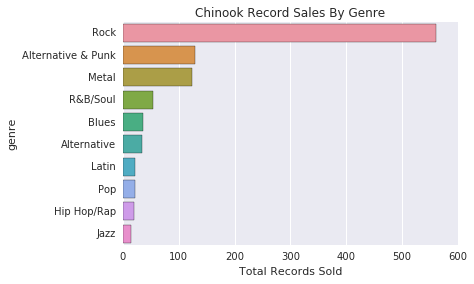

In [7]:
fig, ax = plt.subplots()
sns.set(style="white")
sns.barplot(y=genre_sales_usa.index, x="total_sold", data=genre_sales_usa)
sns.despine(left=True, bottom=True)
ax.set_xlabel('Total Records Sold')
ax.set_title('Chinook Record Sales By Genre')


/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans



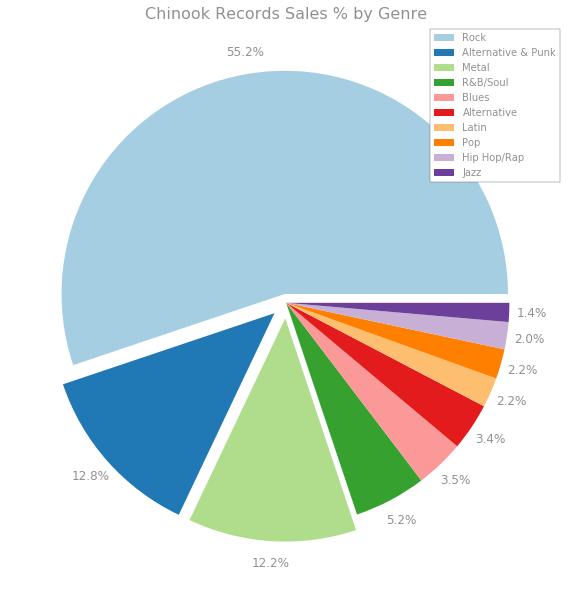

In [8]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=12
plt.rcParams["legend.loc"] = 'upper right'
sns.set_palette(sns.color_palette("Paired", 10))
explode = (0.04, 0.07, 0.07, 0, 0, 0, 0, 0, 0, 0)  

ax = genre_sales_usa.plot.pie(y='total_sold', figsize=(10, 10),
                              explode=explode, autopct='%1.1f%%',
                              pctdistance=1.1, labels=None, wedgeprops={'linewidth':0})

ax.legend(frameon=True, labels=genre_sales_usa.index)
ax.set_title("Chinook Records Sales % by Genre", fontsize = 16)

ax.set_ylabel('')

<h4>Findings</h4><br>
The top selling genres in the USA from the Chinook Record Store are Rock, Alternative & Punk, and Metal. The four new artists Chinook is considering adding are: 

Regal - Hip-Hop <br>
Red Tone - Punk<br>
Meteor and the Girls - Pop<br>
Slim Jim Bites - Blues

Based on the records which sell the best in the USA, if only three of these artists can be added to inventory, my suggestion is to add Red Tone, Meteor and the Girls, and Slim Jim Bites as their respective genres are better sellers than Hip-Hop.

# Analyzing Sales Agent Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. The following process will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [9]:
query2 = '''

        SELECT
            e.first_name || " " || e.last_name employee,
            e.hire_date,
            SUM(i.total) value_added,
            COUNT(i.invoice_id) number_of_sales,
            ROUND(CAST(SUM(i.total) as float)/COUNT(i.invoice_id),2) value_added_per_sale
        FROM invoice i
        INNER JOIN customer c ON i.customer_id = c.customer_id
        INNER JOIN employee e on e.employee_id = c.support_rep_id
        GROUP BY c.support_rep_id
        ORDER BY value_added

'''
run_query(query2)

,employee,hire_date,value_added,number_of_sales,value_added_per_sale
0,Steve Johnson,2017-10-17 00:00:00,1393.92,188,7.41
1,Margaret Park,2017-05-03 00:00:00,1584.00,214,7.40
2,Jane Peacock,2017-04-01 00:00:00,1731.51,212,8.17


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



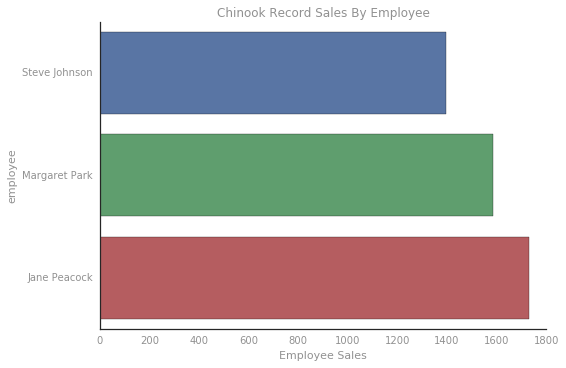

In [10]:
employee_sales = run_query(query2)
fig3, ax3 = plt.subplots()
sns.set(style="white")
sns.barplot(y='employee', x="value_added", data=employee_sales)
sns.despine()
ax3.set_xlabel('Employee Sales')
ax3.set_title('Chinook Record Sales By Employee')



/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



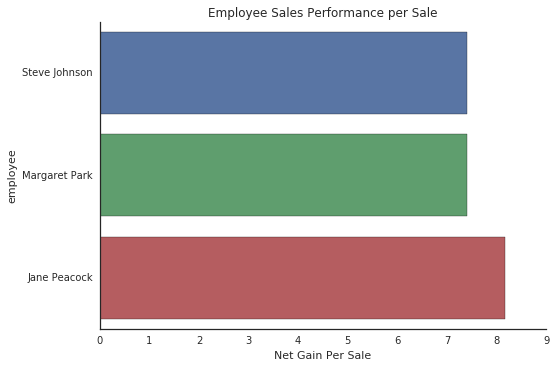

In [11]:
fig4, ax4 = plt.subplots()
sns.set(style="whitegrid")
sns.barplot(y='employee', x="value_added_per_sale", data=employee_sales)
sns.despine()
ax4.set_xlabel('Net Gain Per Sale')
ax4.set_title('Employee Sales Performance per Sale')

<h4>Findings</h4><br>
The salespeople at Chinook all seem to be performing quite similarly on a value added per sale basis. Jane Peacock averages 70 cents more per sale than the other two salespeople, and from a total value added basis, she is far ahead of her coworkers. However, despite these impressive metrics, I don't think this warrants separating her from her coworkers. She has been on the job for the longest period of time, so it makes sense that she has added more total value than the others. Margaret Park was hired one month after Jane, and has sold a simliar amount of records, however, her value added per sale is lesser than that of Jane's. Because the difference is only 70 cents, I believe Margaret could make up ground were she to help process a bulk order. Steve Johnson was hired roughly half a year after Margaret and Jane joined the company, his performance is right in line with Margaret on a per sale basis and his total value added reflects the shorter period of time that he has spent with Chinook. I would say all of the sales people are performing their jobs adequately in relation to eachother, and that, with a longer time frame, it would be possible to gauge whether Jane Peacock continues to pull away from the pack.

# Sales Statistics by Country

In [12]:
query3 = '''

WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT 
    co.country,
    COUNT(DISTINCT(co.customer_id)) number_of_customers,
    COUNT(DISTINCT(co.invoice_id)) number_of_sales,
    SUM(co.unit_price) total_sales,
    ROUND(SUM(co.unit_price) / COUNT(DISTINCT(co.customer_id)),2) customer_lifetime_value,
    ROUND(SUM(co.unit_price) / COUNT(DISTINCT(co.invoice_id)),2) avg_sale_value
FROM country_or_other co
GROUP BY co.country
ORDER BY total_sales DESC


'''

run_query(query3) # for each country find, number of customers, total sales value, avg. customer value, and avg. sale value

,country,number_of_customers,number_of_sales,total_sales,customer_lifetime_value,avg_sale_value
0,Other,15,147,1094.94,73.00,7.45
1,USA,13,131,1040.49,80.04,7.94
2,Canada,8,76,535.59,66.95,7.05
3,Brazil,5,61,427.68,85.54,7.01
4,France,5,50,389.07,77.81,7.78
5,Germany,4,41,334.62,83.66,8.16
6,Czech Republic,2,30,273.24,136.62,9.11
7,United Kingdom,3,28,245.52,81.84,8.77
8,Portugal,2,29,185.13,92.57,6.38
9,India,2,21,183.15,91.58,8.72


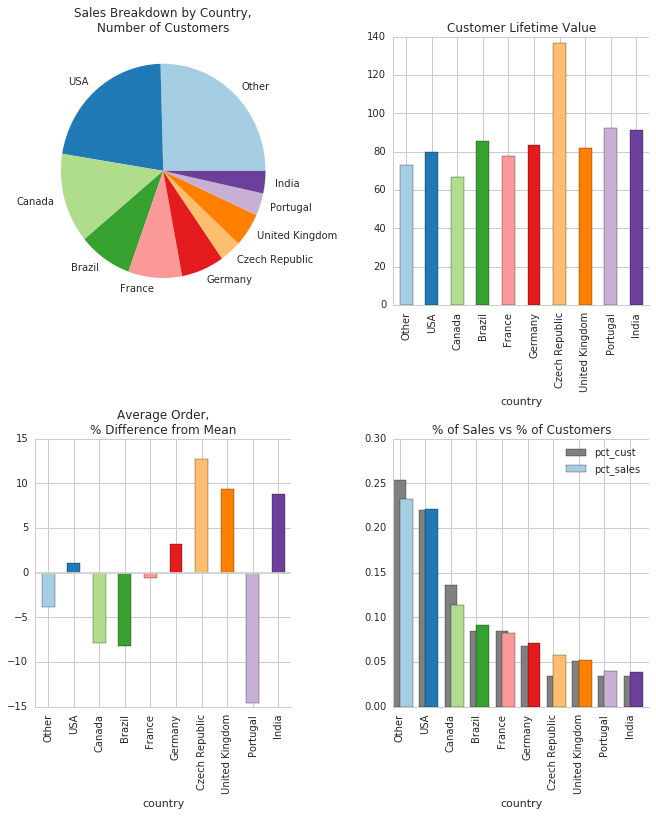

In [13]:
# Create DF from query
country_metrics = run_query(query3)
country_metrics.set_index("country", drop=True, inplace=True)

# Graph Colors
sns.set_palette(sns.color_palette("Paired", 10))


# Adjust figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.4)

# Top left graph
sales_breakdown = country_metrics["number_of_customers"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1, y='number_of_customers', 
    title='Sales Breakdown by Country,\nNumber of Customers', wedgeprops={'linewidth':0})

# Top right graph
lt_value = country_metrics['customer_lifetime_value'].copy()
lt_value.plot.bar(ax=ax2, x='country',y='customer_lifetime_value', title='Customer Lifetime Value')
sns.despine()

# Bottom left graph
avg_price_per_sale = country_metrics['avg_sale_value'].copy()
mean_sale = np.mean(avg_price_per_sale)
diff_from_avg_sale = avg_price_per_sale - mean_sale
(diff_from_avg_sale*10).plot.bar(
    ax=ax3,
    title="Average Order,\n% Difference from Mean"
)
ax3.axhline(0, color='lightgrey')

# Bottom right graph

# Get each country's percentage of total sales
total_sales = country_metrics['total_sales'].copy()
pct_sales = [c/(np.sum(total_sales)) for c in country_metrics['total_sales']]

# Get each country's percentage of total customers
pct_cust = [c/(np.sum(sales_breakdown)) for c in country_metrics['number_of_customers']]

# Add series back to original DF
country_metrics['pct_cust'] = pct_cust
country_metrics['pct_sales'] = pct_sales

# Plot results
country_metrics.plot.bar(ax=ax4, y='pct_cust', color = 'grey', title = '% of Sales vs % of Customers')
country_metrics.plot.bar(ax=ax4, y='pct_sales', align='edge')
sns.despine()

<h4>Findings</h4><br>

Keeping in mind that this is a small sample size, we are looking for countries where the % of sales is higher than the % of customer. This will indicate countries with high lifetime values who are likely to spend more per purchase. Czech Republic, the UK, and India are the best markets for Chinook to expand into. 

# Optimizing Purchasing Strategies

The record store allows it's customers to make purchases in one of two ways:
- Purchase an album
- Purchase a collection of individual tracks <br>

The store does not allow individuals to purchase an entire album and then add tracks individually to that purchase unless the customer manually chooses the each track from the album themselves. Management is considering changing their purchasing policy in order to save money. Their idea is to allow customers to purchase a selection of only the most popular tracks from the album as opposed to each track on the album. 

To gauge the effectiveness of this initiative, Management is interested in knowing what percentage of purchases are individual tracks vs whole albums

In [61]:
q4= '''

WITH track1 AS
    (
        SELECT 
            il.invoice_id,
            MIN(il.track_id) track1_id,
            t.album_id
        FROM invoice_line il
        INNER JOIN track t ON il.track_id = t.track_id
        GROUP BY il.invoice_id
    )
    
SELECT
album_purchase,
COUNT(invoice_id) num_of_invoices,
CAST(COUNT(invoice_id) AS FLOAT) / ( SELECT COUNT(*) FROM invoice) percentage
FROM (
    SELECT
        t1.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = t1.track1_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = t1.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = t1.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = t1.track1_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM track1 t1
    )
GROUP BY album_purchase;


'''

run_query(q4)

,album_purchase,num_of_invoices,percentage
0,no,500,0.814332
1,yes,114,0.185668


Individual customers prefer to purchase singles from albums (~80%) as opposed to album purchases (~20%). However, there is no way to discern which tracks a given customer wants to purchase from an album. Additionally, the full album purchases do contribute to the bottom line. For this reason, I would recommend that the store continue to purchase full albums. 